EDA的邏輯：
我好奇的問題
存活率多少？性別有差嗎？票價？年紀？
# ---------------- Clarifying Questions 模板（你拿到任何 dataset 都可以先想這些） ----------
# Q1. 目標是什麼？（Business / Task）
#     - 這是分類？迴歸？ranking？forecast？ 
#     - Titanic：預測 Survived（二元分類）
#
# Q2. 目標欄位是哪一個？（target / label）
#     - Titanic：Survived（1=活，0=死）
#
# Q3. 每個欄位的「業務意義」是什麼？
#     - Pclass：艙等 → 社經地位 / 船艙位置
#     - Sex：性別 → 救援優先順序
#     - Age：年齡 → 老/幼的差異
#     - SibSp, Parch：有多少家人同行 → 家庭結構
#     - Fare：票價 → 財力 / 艙等 proxy
#     - Embarked：登船港口 → 旅客來源結構
#
# Q4. 這些欄位裡，哪些「直覺上」可能跟目標有關？
#     - 跟人本身特徵有關：Sex, Age, Pclass, Fare, FamilySize
#     - 跟時間、地點、行為有關：Embarked
#
# Q5. 這個問題比較在意什麼錯誤？
#     - Titanic：漏掉本來可以活的人（FN, Type II error）比較嚴重
#
# 你每次遇到新案子，可以先用這 5 題把方向定出來，再寫 code。

In [5]:
import pandas as pd 
import matplotlib as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [8]:
test = pd.read_csv('test.csv')
print(test.head())
test.info()
test.isnull().sum()

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       ------------

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
train = pd.read_csv('train.csv')
print(train.head())
train.info()
train.isnull().sum()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

看存活率

In [14]:
survival_rate = train["Survived"].value_counts(normalize=True)
print(f"{survival_rate[1]*100:.2f}% survived, {survival_rate[0]*100:.2f}% did not survive.")

38.38% survived, 61.62% did not survive.


看性別存活率是否有差異

In [15]:
sex_survival = train.groupby("Sex")["Survived"].mean()
print(sex_survival)

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [16]:
#### 看艙等是否有差異
pclass_survival = train.groupby("Pclass")["Survived"].mean()
print(pclass_survival)

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [ ]:
##### 看年紀
train["Age"].describe()

AgeGroup
0~10     0.612903
10~20    0.401961
20~30    0.350000
30~40    0.437126
40~50    0.382022
50~60    0.416667
60~70    0.315789
70~80    0.000000
Name: Survived, dtype: float64


/var/folders/xk/bs6_x4n50mg093799523_3zm0000gn/T/ipykernel_84950/3627353724.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = train.groupby("AgeGroup")["Survived"].mean()


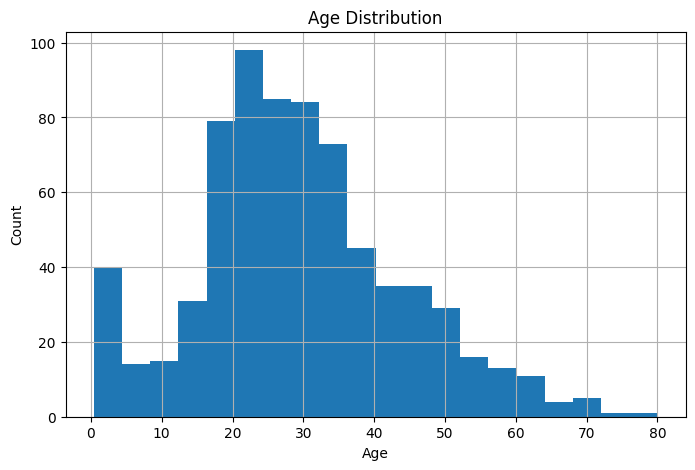

In [ ]:
plt.figure(figsize=(8,5))
train["Age"].hist(bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

In [24]:
import plotly.express as px

# 計算每個年齡區間、每個性別的生存率
grouped = train.groupby(["AgeGroup", "Sex"])["Survived"].mean().reset_index()

fig = px.bar(
    grouped,
    x="AgeGroup",
    y="Survived",
    color="Sex",
    barmode="group",
    title="生存率：不同年齡區間 x 性別",
    text_auto=True
)

fig.show()

/var/folders/xk/bs6_x4n50mg093799523_3zm0000gn/T/ipykernel_84950/3882507518.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train.groupby(["AgeGroup", "Sex"])["Survived"].mean().reset_index()


In [28]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
family_survival = train.groupby("FamilySize")["Survived"].mean()
print(family_survival)

FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64


In [30]:
family_plot = train.groupby("FamilySize")["Survived"].mean().reset_index()

fig = px.bar(
    family_plot,
    x="FamilySize",
    y="Survived",
    title="FamilySize vs Survived",
    color="FamilySize",
    color_continuous_scale="Earth"  # 大地色系（Plotly 的 Earth 色盤）
)

fig.show()

In [32]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
AgeGroup       178
FamilySize       0
dtype: int64

In [34]:
# 用中位數補 Age 缺失值
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Age"].isnull().sum()

np.int64(0)

In [35]:
train = train.drop(columns=["Cabin"])
"Cabin" in train.columns

False

In [36]:
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])
train["Embarked"].isnull().sum()

np.int64(0)

In [ ]:
##### 轉換sex變成0 or 1
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
train["Sex"].value_counts()

Series([], Name: count, dtype: int64)

In [39]:
##### 把上岸港口轉換成數值
train = pd.get_dummies(train, columns=["Embarked"], drop_first=True)

In [47]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,2,False,False
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,1,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2,False,True
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,1,False,True


In [41]:
train["Sex"].unique()

array([nan])

In [ ]:
#### sex被修成nan，用這系列修正
import pandas as pd

# 1. 重新讀取原始資料
train = pd.read_csv("train.csv")

# 2. 建立 FamilySize（剛剛有做過，再做一次就好）
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1

# 3. 補 Age（用中位數）
train["Age"] = train["Age"].fillna(train["Age"].median())

# 4. 刪掉 Cabin
train = train.drop(columns=["Cabin"])

# 5. 補 Embarked（用眾數）
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

# 6. Sex 映射成 0/1（這次是從原始 male/female 來）
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})

# 7. Embarked 做 one-hot encoding
train = pd.get_dummies(train, columns=["Embarked"], drop_first=True)

In [45]:
train["Sex"].unique()


array([0, 1])

In [46]:
train["Sex"].isnull().sum()

np.int64(0)

開始建模！！！
挑選幾個特徵：
倉等、性別、年齡、家戶數、在哪上船
先建模型、等等會解釋為什麼會認為這些可以當特徵


In [50]:
features = [
    "Pclass",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "FamilySize",
    "Embarked_Q",
    "Embarked_S",
]

X = train[features]
y = train["Survived"]

In [51]:
X.isnull().sum()
y.isnull().sum()

np.int64(0)

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,        # 20% 當驗證集
    random_state=42,      # 固定亂數，讓結果可重現
    stratify=y            # 依 Survived 分層抽樣 → 生存/死亡比例一致
)

In [53]:
X_train.shape, X_val.shape

((712, 9), (179, 9))

In [54]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 用模型在驗證集上做預測
y_pred = model.predict(X_val)

# 1. 準確率
print("Accuracy:", accuracy_score(y_val, y_pred))

# 2. 混淆矩陣
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# 3. 分類報告（precision, recall, f1）
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8044692737430168
Confusion Matrix:
 [[98 12]
 [23 46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



複習一下混淆矩陣
type1 error = 實際是死亡，但是錯誤預測成生存 12
type2 error = 實際是生存，被錯誤預測成死亡 23
在救援場景中，Type II 更嚴重
因為會把「需要救的人」當作「不用救」。
實務上最怕漏掉「高風險但可以被救的人」
Titanic 的情境和醫療檢測類似：
「漏掉需要救的人」比「誤以為某人需要救」更糟。

In [60]:
##### 列出 Logistic Regression 的特徵係數
print(f"Logistic Regression 的特徵係數:\n")
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_[0]
})

coefficients.sort_values(by="Coefficient", ascending=False)

Logistic Regression 的特徵係數:



,Feature,Coefficient
1,Sex,2.561320
7,Embarked_Q,0.273992
4,Parch,0.030757
5,Fare,0.002262
2,Age,-0.038560
6,FamilySize,-0.102998
3,SibSp,-0.143376
8,Embarked_S,-0.380978
0,Pclass,-1.090497


接下來是Step5 會使用random Forst

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,     # 樹的數量，不要太少
    max_depth=None,       # 自動讓模型決定深度
    random_state=42,      # 固定亂數
    class_weight="balanced"  # 針對生存者（1）偏少的問題做補正
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=400,
                       random_state=42)

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_rf = rf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))

Accuracy: 0.8212290502793296
Confusion Matrix:
 [[96 14]
 [18 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [65]:
import pandas as pd

rf_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

rf_importance

,Feature,Importance
5,Fare,0.271992
1,Sex,0.259378
2,Age,0.244184
0,Pclass,0.079533
6,FamilySize,0.055583
3,SibSp,0.029453
8,Embarked_S,0.025546
4,Parch,0.024653
7,Embarked_Q,0.009679


Step6: 開始預測

In [ ]:
test = pd.read_csv("test.csv")
test.head()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [77]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
FamilySize     0
dtype: int64

In [72]:
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

In [73]:
# 使用 train 的 Age 中位數來補 test 的 Age
age_median = train["Age"].median()
test["Age"] = test["Age"].fillna(age_median)

In [74]:
##### 刪掉 Cabin
test = test.drop(columns=["Cabin"])


In [76]:
# 取 3 等艙的中位數 Fare
fare_median_class3 = test[test["Pclass"] == 3]["Fare"].median()

# 補入缺失值
test["Fare"] = test["Fare"].fillna(fare_median_class3)

In [78]:
# 取得模型使用的欄位名稱
required_features = X_train.columns

# 如果 test 缺少某些欄位（例如 Embarked_Q），就補 0
for col in required_features:
    if col not in test.columns:
        test[col] = 0

# 如果 test 有多餘欄位（例如 Name、Ticket），就丟掉
test = test[required_features]

開始預測

In [81]:
##### 徹底清洗test

# 1. 重新讀 test.csv（避免之前亂掉的狀態）
test_raw = pd.read_csv("test.csv")

# 2. 建立 FamilySize（跟 train 一樣）
test_raw["FamilySize"] = test_raw["SibSp"] + test_raw["Parch"] + 1

# 3. 補 Age：用「現在這個 train 裡的 Age 中位數」
age_median = train["Age"].median()
test_raw["Age"] = test_raw["Age"].fillna(age_median)

# 4. 補 Fare：用各艙等(Pclass)的中位數
test_raw["Fare"] = test_raw["Fare"].fillna(
    test_raw.groupby("Pclass")["Fare"].transform("median")
)

# 5. 刪掉 Cabin（test 裡如果還有就刪掉）
if "Cabin" in test_raw.columns:
    test_raw = test_raw.drop(columns=["Cabin"])

# 6. Sex 編碼：male -> 0, female -> 1
test_raw["Sex"] = test_raw["Sex"].map({"male": 0, "female": 1})

# 7. Embarked one-hot，跟 train 當初一樣：drop_first=True
#    這樣會產生 Embarked_Q、Embarked_S（或少一個，我們後面補）
test_raw = pd.get_dummies(test_raw, columns=["Embarked"], drop_first=True)

# 8. 對齊欄位：讓 test 跟 X_train 用到的特徵完全一致
required_features = X_train.columns

# 補齊 test 裡缺少的欄位（例如 Embarked_Q）
for col in required_features:
    if col not in test_raw.columns:
        test_raw[col] = 0  # 缺的就補 0

# 只保留模型需要的欄位，而且順序跟 X_train 一模一樣
test_clean = test_raw[required_features]

# 檢查一下型別與缺失
print(test_clean.dtypes)
print(test_clean.isnull().sum())

Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
FamilySize      int64
Embarked_Q       bool
Embarked_S       bool
dtype: object
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
FamilySize    0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [83]:
test_clean["Embarked_Q"] = test_clean["Embarked_Q"].astype(int)
test_clean["Embarked_S"] = test_clean["Embarked_S"].astype(int)
print(test_clean.dtypes)

Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
FamilySize      int64
Embarked_Q      int64
Embarked_S      int64
dtype: object


/var/folders/xk/bs6_x4n50mg093799523_3zm0000gn/T/ipykernel_84950/406531023.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xk/bs6_x4n50mg093799523_3zm0000gn/T/ipykernel_84950/406531023.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
# 1. 用已經訓練好的 rf 做預測
test_pred = rf.predict(test_clean)

# 2. 建立 submission dataframe
test_original = pd.read_csv("test.csv")  # 只拿 PassengerId
submission = pd.DataFrame({
    "PassengerId": test_original["PassengerId"],
    "Survived": test_pred
})

# 3. 輸出成 Kaggle 要的格式
submission.to_csv("submission.csv", index=False)
print("submission.csv 已經建立好了")

submission.csv 已經建立好了


In [84]:
submission.shape

(418, 2)

以下是論證環節，把這個資料集徹底拆開

In [96]:
# 1. 讀資料 & 初步檢查
# =========================================================

df = pd.read_csv("train.csv")
print(df.head())

print("\n=== 資訊概要 ===")
print(df.info())

print("\n=== 缺失值統計 ===")
print(df.isnull().sum())

# 目標欄位

target_col = "Survived"

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

=

In [98]:
# 2. 最基本的 EDA（看方向）
# =========================================================

# (1) 整體存活率
survival_rate = df[target_col].mean()
print(f"\n整體存活率: {survival_rate:.3f} ({survival_rate*100:.2f}%)")

# (2) 按 Sex 看存活率
sex_survival = df.groupby("Sex")[target_col].mean()
print("\n依性別的存活率：")
print(sex_survival)

# (3) 按 Pclass 看存活率
pclass_survival = df.groupby("Pclass")[target_col].mean()
print("\n依艙等的存活率：")
print(pclass_survival)

# (4) 年齡分組存活率（每 10 歲一組）
bins = range(0, 90, 10)
labels = [f"{i}-{i+9}" for i in bins[:-1]]
df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)

agegroup_survival = df.groupby("AgeGroup")[target_col].mean()
print("\n依年齡區間的存活率：")
print(agegroup_survival)




整體存活率: 0.384 (38.38%)

依性別的存活率：
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

依艙等的存活率：
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

依年齡區間的存活率：
AgeGroup
0-9      0.593750
10-19    0.382609
20-29    0.365217
30-39    0.445161
40-49    0.383721
50-59    0.404762
60-69    0.235294
70-79    0.200000
Name: Survived, dtype: float64


/var/folders/xk/bs6_x4n50mg093799523_3zm0000gn/T/ipykernel_84950/3254966312.py:23: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [99]:
# (5) 建 FamilySize，看看家庭大小與存活率
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
family_survival = df.groupby("FamilySize")[target_col].mean()
print("\n依家庭大小(FamilySize) 的存活率：")
print(family_survival)

# 上面這些數字就是你在作品集裡可以用的「量化洞察」：
# - 女性 vs 男性存活率差多少
# - 一等艙 vs 三等艙差多少
# - 家庭人數 1, 2-4, 5+ 的差異


依家庭大小(FamilySize) 的存活率：
FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64


為什麼特徵選用這些
✔ 1. Embarked 與 Pclass 有強關聯

（階級差異 → 生存率差異）

✔ 2. Embarked 與 Fare 有強關聯

（越貴的人越容易活）

✔ 3. Embarked 與 Survived 本身也有統計差異

（groupby 一看就知道）

以上三件事都來自於資料本身，而不是故事背景。

In [ ]:
raw = pd.read_csv("train.csv")

print("=== 不同港口的艙等分布（%） ===")
print(raw.groupby("Embarked")["Pclass"].value_counts(normalize=True))

print("\n=== 不同港口的票價中位數 ===")
print(raw.groupby("Embarked")["Fare"].median())

print("\n=== 不同港口的存活率 ===")
print(raw.groupby("Embarked")["Survived"].mean())

=== 不同港口的艙等分布（%） ===
Embarked  Pclass
C         1         0.505952
          3         0.392857
          2         0.101190
Q         3         0.935065
          2         0.038961
          1         0.025974
S         3         0.548137
          2         0.254658
          1         0.197205
Name: proportion, dtype: float64

=== 不同港口的票價中位數 ===
Embarked
C    29.70
Q     7.75
S    13.00
Name: Fare, dtype: float64

=== 不同港口的存活率 ===
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


交叉分析

In [104]:
### 不同港口 × 性別 的存活率
raw.groupby(["Embarked", "Sex"])["Survived"].mean()

Embarked  Sex   
C         female    0.876712
          male      0.305263
Q         female    0.750000
          male      0.073171
S         female    0.689655
          male      0.174603
Name: Survived, dtype: float64

In [105]:
#### 不同港口 × 艙等 × 性別 的存活率
raw.groupby(["Embarked", "Pclass", "Sex"])["Survived"].mean()

Embarked  Pclass  Sex   
C         1       female    0.976744
                  male      0.404762
          2       female    1.000000
                  male      0.200000
          3       female    0.652174
                  male      0.232558
Q         1       female    1.000000
                  male      0.000000
          2       female    1.000000
                  male      0.000000
          3       female    0.727273
                  male      0.076923
S         1       female    0.958333
                  male      0.354430
          2       female    0.910448
                  male      0.154639
          3       female    0.375000
                  male      0.128302
Name: Survived, dtype: float64

In [108]:
### 不同港口 × 家庭大小 的存活率
raw["FamilySize"] = raw["SibSp"] + raw["Parch"] + 1
raw.groupby(["Embarked", "FamilySize"])["Survived"].mean()

Embarked  FamilySize
C         1             0.435294
          2             0.666667
          3             0.608696
          4             0.857143
          5             1.000000
Q         1             0.403509
          2             0.555556
          3             0.333333
          6             0.000000
S         1             0.256997
          2             0.495050
          3             0.589041
          4             0.681818
          5             0.076923
          6             0.176471
          7             0.333333
          8             0.000000
          11            0.000000
Name: Survived, dtype: float64

In [107]:
###不同港口 × 艙等 的票價中位數
raw.groupby(["Embarked", "Pclass"])["Fare"].median()

Embarked  Pclass
C         1         78.2667
          2         24.0000
          3          7.8958
Q         1         90.0000
          2         12.3500
          3          7.7500
S         1         52.0000
          2         13.5000
          3          8.0500
Name: Fare, dtype: float64